# Assigment

The following notebook contains the base architecture for the assignment.

The task is to complete the missing parts, explore the datasets and build two simple binary classifier, one which consists only of fully connected layers and one which also incorporates convolutional and max-pooling layers.

Only numpy is allowed to implement the classes! (Matplotlib and other modules can be used for visualization and data exploration.)

**Due date:** 2019 december 15

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Optimizers

In [2]:
class Optimizer:
  def update(self, param, grad):
    pass
  
  def __call__(self, param, grad):
    self.update(param, grad)
  
  
class SGD(Optimizer):
  def __init__(self, learning_rate):
    self.learning_rate = learning_rate
  
  def update(self, param, grad):
    '''Gradient Descent Update
    This function updates the given 'param' using the 'grad' (gradients). 
    Note #1: Use the learning_rate. 
    Note #2: There are no return values.
    
    :param param: Parameters of the layer.
    :param grad: Corresponding gradients.
    '''
    param -= self.learning_rate * grad

# Weight Initializers

In [3]:
class WeigthInitializer:
  def initialize(self, size):
    return np.ones(size, dtype=np.float)
  
  def __call__(self, size):
    return self.initialize(size)
  

class RandomInitializer(WeigthInitializer):
  def __init__(self, shift=-0.5, scale=0.2):
    self.shift = shift
    self.scale = scale
    
  def initialize(self, size):
    '''Random number initializer
    Note #1: 'self.scale' specifies the range of the values and with 'self.shift' they can be shifted.
    Note #2: By default (with scale=0.2 and shift=-0.5) it should return a matrix which contains random values between -0.1 and 0.1. 
    Note #3: Use the np.random modul!

    :param size: Dimensions of the matrix.
    :returns: A matrix of random numbers with dimensions specified by 'size'. 
    '''
    return (np.random.random(size) + self.shift)*self.scale

# Function class

In [4]:
class Function:
  def forward(self, input):
    return None  
  
  def __call__(self, input):
    return self.forward(input)
  
  def backward(self, grads):
    return None

## Activation functions

In [5]:
class Activation(Function):
  def __init__(self):
    pass
  
  
class Linear(Activation):
  def forward(self, z):
    return z.astype(np.float)

  def backward(self, z):
    return np.ones_like(z, dtype=np.float)


class Relu(Activation):
  def forward(self, z):
    '''Forward pass of the Rectified Linear Unit activation function.

    :param z: Input tensor.
    :returns: ReLU(z), see the lecture notes for the definition. 
    '''
    return np.where(z>0, z, 0.)

  def backward(self, z):
    '''Backward pass of the Rectified Linear Unit activation function.

    :param z: Input tensor.
    :returns: ReLU'(z), see the lecture notes for the definition. 
    '''
    return np.where(z>0, 1., 0.) 

  
class Sigmoid(Activation):
  def forward(self, z):
    '''Forward pass of the Sigmoid activation function.

    :param z: Input tensor.
    :returns: sigmoid(z), see the lecture notes for the definition. 
    '''
    return self.sigmoid(z)
  
  def backward(self, z):
    '''Backward pass of the Sigmoid activation function.

    :param z: Input tensor.
    :returns: sigmoid'(z), see the lecture notes for the definition. 
    '''
    sig = self.sigmoid(z)
    return sig*(1-sig)  

  def sigmoid(self, z):
    return 1/(1 + np.exp(-z))

## Loss functions

In [6]:
class Loss(Function):
  def forward(self, y_true, y_pred):
    return None
  
  def __call__(self, y_true, y_pred):
    return self.forward(y_true, y_pred)
  
  def backward(self, y_true, y_pred):
    return None
  
  
class BinaryCrossentropy(Loss):
  def forward(self, y_true, y_pred):
    '''Forward pass of the Binary Crossentropy loss.
    Note: Both 'y_true' and 'y_pred' contains a batch of labels => y_true.shape == y_pred.shape == <batch size> x 1 

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :returns: Binary crossentropy loss, see the lecture notes for the definition. 
    '''
    assert y_true.shape == y_pred.shape
    
    losses = np.where(y_true == 1, -y_true*np.log(y_pred), -(1-y_true)*np.log(1-y_pred))
    return np.mean(losses)
  
  def backward(self, y_true, y_pred):
    '''Backward pass of the Binary Crossentropy loss.
    Note #1: The gradient should have the same shape as y_pred (<batch size> x 1) 
    Note #2: Keep in mind that the derivative of the loss in the lecture notes is for a logistic regression model. 
    Note #3: Here, you do not need to derive respect to the weights! 

    :param y_true: Ground truth labels.
    :param y_pred: Predicted labels.
    :returns: Derivative of the binary crossentropy loss, see the lecture notes for the "definition". 
    '''
    return np.where(y_true==1, -(y_true/y_pred) , (1-y_true)/(1-y_pred))

## Layers

In [7]:
class Layer(Function):
  def __init__(self, activation, optimizer=None, weight_init=RandomInitializer(), *args, **kwargs):
    self.activation = activation
    self.optimizer = optimizer
    self.weight_init = weight_init
  
  def _forward(self, x):
    return None
  
  def forward(self, X):
    self.X = X
    self.Z = self._forward(X)
    self.h = self.activation(self.Z)
    return self.h
  
  def _backward(self, dZ):
    return None, None
  
  def backward(self, dh):
    dZ = dh * self.activation.backward(self.Z)
    self.dX, self.grads = self._backward(dZ)
    self._update_weights()
    return self.dX
  
  def _update_weights(self):
    assert len(self.params) == len(self.grads)
    for idx in range(len(self.params)):
      self.optimizer(self.params[idx], self.grads[idx])

### Fully-connected (dense) layer

In [8]:
class Dense(Layer):
  def __init__(self, size, *args, **kwargs):
    super(Dense, self).__init__(*args, **kwargs)
    self.W = self.weight_init(size)
    self.b = self.weight_init((1, size[1]))
    self.params = [self.W, self.b]
    
  def _forward(self, X):
    '''Forward pass of the dense layer.
    Note #1: Use self.W and self.b
    Note #2: Input times weight add a bias ==> activate is already taken care of! (see self.forward())

    :param X: Input matrix
    :returns: Linear combination, see the lecture notes for the definition.
    '''
    return np.dot(X, self.W) + self.b 

  def _backward(self, dZ):
    '''Backward pass of the dense layer.
    Note: Use self.X

    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX and [dW, db]) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''
    batch_size = dZ.shape[0]
    dW = np.dot(self.X.T, dZ) / batch_size
    db = dZ.mean(axis=0)
    dX = np.dot(dZ, self.W.T)
    return dX, [dW, db]

### Flatten

In [ ]:
class Flatten(Layer):
  def __init__(self, *args, **kwargs):
    super(Flatten, self).__init__(activation=Linear(), *args, **kwargs)
  
  def _forward(self, X):
    return X.reshape((len(X), -1))

  def _backward(self, dZ):
    return dZ.reshape(self.X.shape), []
  
  def _update_weights(self):
    pass

### Max pooling

In [ ]:
class Maxpool2d(Layer):
  def __init__(self, *args, **kwargs):
    super(Maxpool2d, self).__init__(activation=Linear(), *args, **kwargs)
  
  def _forward(self, X):
    '''Forward pass of the max pooling layer.

    :param X: Input matrix
    :returns: Matrix (<batch_size> x <height>//2 x <width>//2 x <n_channels>) after max pooling, see the lecture notes for the definition.
    '''    
    self.mask = None  # TODO save the mask for later (_backward) use.
    return None  # TODO

  def _backward(self, dZ):
    '''Backward pass of the max pooling layer.
    Note: Use self.mask too.

    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX and []) which contains the partial derivative respect to the input and an empty list. See the lecture notes for the "definition".
    '''
    dX = None  # TODO
    return dX, []
  
  def _update_weights(self):
    pass

### Convolutional layer

In [ ]:
class Conv2d(Layer):
  def __init__(self, kernel_size, n_channels, n_kernels, pad, use_fast=False, *args, **kwargs):    
    super(Conv2d, self).__init__(*args, **kwargs)
    self.W = self.weight_init((kernel_size, kernel_size, n_channels, n_kernels))
    self.b = self.weight_init((1, 1, 1, n_kernels))
    self.params = [self.W, self.b]
    self.pad = pad
    self.use_fast = use_fast
  
  def _convolution_fast(self, Y):
    '''Optimized version of the convolution operation (Optional).
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: There are no return values.
    Note #3: It's an optional task.
    
    :param Y: Destination (output) matrix (image), see the lecture notes for the "definition". 
    '''    
    pass  # TODO optional
    
  def _convolution_slow(self, Y):
    '''Naive version (with a bunch of for loops) of the convolution operation.
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: There are no return values.
    Note #3: Both convolution and cross-correlation is acceptable.
    
    :param Y: Destination (output) matrix (image), see the lecture notes for the "definition". 
    '''    
    pass  # TODO

  def _forward(self, X):
    y_height = X.shape[1] - self.W.shape[0] + 2*self.pad + 1
    y_width = X.shape[2] - self.W.shape[1] + 2*self.pad + 1
    Y = np.zeros((X.shape[0], y_height, y_width, self.W.shape[3]), dtype=np.float16)
    
    if 0 < self.pad:
      X_padded = # TODO pad the input
    else:
      X_padded = X
    self.X_padded = X_padded
    
    if self.use_fast:
      self._convolution_fast(Y)
    else:
      self._convolution_slow(Y)
    
    Y += self.b
    return Y
  
  def _backward_fast(self, dZ):
    '''Optimized version of the backward pass (Optional).
    Note #1: Use self.X, self.X_padded, self.W
    Note #2: It's an optional task.
    
    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX, dW and db) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''    
    db = None  # None optional
    dW = None  # None optional
    dX = None  # None optional
    return dX, dW, db

  def _backward_slow(self, dZ):
    '''Naive version (with a bunch of for loops) of the backward pass.
    Note: Use self.X, self.X_padded, self.W
    
    :param dZ: Gradient of the subsequent layer.
    :returns: A pair (dX, dW and db) which contains the partial derivatives respect to the input and to the parameters (W and b). See the lecture notes for the "definition".
    '''    
    db = None  # None
    dW = None  # None
    dX = None  # None 
    return dX, dW, db
  
  def _backward(self, dZ):
    if self.use_fast:
      dX, dW, db = self._backward_fast(dZ)
    else:
      dX, dW, db = self._backward_slow(dZ)
    
    if 0 < self.pad:
      dX = dX[:, self.pad:-self.pad, self.pad:-self.pad, :]
    
    return dX, [dW, db]
    

# Model class

In [21]:
class Model:
  def __init__(self, layers=None, loss=None, optimizer=None):
    self.layers = []
    if layers is not None:
      self.layers = layers
    self.loss = loss
    self.optimizer = optimizer
  
  def add(self, layer):
    assert isinstance(layer, Layer)
    layer.optimizer = self.optimizer
    self.layers.append(layer)
  
  def train(self, x_train, y_train, n_epochs, batch_size, randomize=True, display=True):
    self.losses = []
    for epoch in range(n_epochs):
      idx_list = list(range(len(x_train)))
      if randomize:
        np.random.shuffle(idx_list)
      n_batches = (len(idx_list) + batch_size - 1) // batch_size
      loss = 0.
      for batch_idx in range(n_batches):
        data = x_train[idx_list[batch_idx * batch_size:(batch_idx + 1) * batch_size]]
        
        # forward pass
        for l in self.layers:
            data = l.forward(data)
        
        # loss
        y_pred = data
        y_true = y_train[idx_list[batch_idx * batch_size:(batch_idx + 1) * batch_size]]
        # to make y_pred have the same shape as y_true
        y_true = y_true[:, np.newaxis]
        
        batch_loss = self.loss(y_true, y_pred)
        loss += batch_loss

        # backward pass
        curr_grad = self.loss.backward(y_true, y_pred)
        for l in reversed(self.layers):
            curr_grad = l.backward(curr_grad) 

        # display
        # print('Epoch {}/{}: batch {}/{}: batch_loss: {}, avg_loss: {}'.format(epoch+1, n_epochs, batch_idx+1, n_batches, batch_loss, loss/(batch_idx+1)))  #, end='\r')
      print('Epoch {}/{}: loss: {}'.format(epoch+1, n_epochs, loss/n_batches))
      self.losses.append(loss / n_batches)
    if display:
      # Plot the learning curve after training.
      plt.title("Binary cross entropy lost on the train set over the epochs")
      plt.xlabel("Epoch")
      plt.ylabel("Binary cross entropy loss")
      plt.plot(np.arange(len(self.losses)), self.losses)
      plt.show()
  
  def predict(self, x_test, display=True):
    data = x_test
    for l in self.layers:
        data = l.forward(data)
    return data

# Breast Cancer Wisconsin (Diagnostic) Dataset

For more information, see: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [10]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

--2019-12-03 12:36:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 124103 (121K) [application/x-httpd-php]
Saving to: ‘wdbc.data.33’

wdbc.data.33        100%[===================>] 121,19K  75,1KB/s    in 1,6s    

2019-12-03 12:37:00 (75,1 KB/s) - ‘wdbc.data.33’ saved [124103/124103]



In [11]:
filename = 'wdbc.data'

with open(filename, 'r') as file:
  lines = file.readlines()
  
words = [line.split(',') for line in lines]
data = words[:-1]

features = [[float(item) for item in rec[2:]] for rec in data]
features = np.array(features, dtype=np.float32)

label_str_to_num = lambda label: 1. if label == 'M' else 0.
labels = [label_str_to_num(rec[1]) for rec in data]
labels = np.array(labels, dtype=np.float32)

# removing records with missing features (if any feature == 0.)
missing_features = np.any(features == 0., axis=1)
features = features[~missing_features,:]
labels = labels[~missing_features]

print(features.shape)
print(labels.shape)

(556, 30)
(556,)


## Data exploration and Pre-processing
Tasks:
* Print the distribution of the labels.
* Print the scales of each features. (min, max, avg, std)
* Randomly split the dataset to training and test sets. (Ratio should be 80-20.)
  * After splitting make sure that the distribution of the labels are similar. (Print the distribution of the labels.)
* Normalize the data by each feature. (Use Z-score standardization.)

In [12]:
#packages for data exploration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score
import pandas as pd

In [13]:
def print_label_distributions(labels):
    positive_indices = labels == 1
    negative_indices = labels == 0

    num_positive = np.sum(positive_indices)
    num_negative = np.sum(negative_indices)
    print("Positive labels:", num_positive)
    print("Negative labels:", num_negative)
    print("Positive/Negative ration: ", num_positive/num_negative)
    print("\n")

### Label distribution

In [14]:
print_label_distributions(labels)

Positive labels: 212
Negative labels: 344
Positive/Negative ration:  0.6162790697674418




### The scales of the features

In [15]:
feature_count = features.shape[1]
print("Number of features: ", feature_count)

feature_df = pd.DataFrame(features)
feature_df.describe().loc[["mean", "std", "min", "max"]]

Number of features:  30


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
mean,14.237565,19.259748,92.736679,663.734741,0.096616,0.105679,0.090876,0.050063,0.181278,0.062746,...,16.407686,25.679388,108.242882,893.412415,0.132824,0.258471,0.278553,0.117286,0.290802,0.084141
std,3.482170,4.246993,24.006363,350.893311,0.013895,0.052643,0.079468,0.038517,0.027446,0.007059,...,4.797695,6.105744,33.337040,569.492920,0.022616,0.156663,0.206803,0.064087,0.062027,0.018130
min,7.691000,9.710000,48.340000,170.399994,0.062510,0.019380,0.000692,0.001852,0.116700,0.049960,...,8.678000,12.020000,54.490002,223.600006,0.081250,0.034320,0.001845,0.008772,0.156500,0.055040
max,28.110001,39.279999,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040001,49.540001,251.199997,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### Z-score nomalization

In [16]:
scaler = StandardScaler()
transformed_features = scaler.fit_transform(features)

### Train-test split

In [17]:
train_features, test_features, train_labels, test_labels = train_test_split(transformed_features, labels, 
                                                                            test_size=0.2, stratify=labels)
print_label_distributions(train_labels)

Positive labels: 169
Negative labels: 275
Positive/Negative ration:  0.6145454545454545




## Define and train a model.
Tasks:
* Define a 2 layer fully-connected network:
  1. layer with 5 units and ReLU activation.
  2. layer with 1 units and Sigmoid activation.
* Train it for 500 epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01.
* Plot the learning curve.
  * Summmarize in a few words what you see. (Presence of overfitting, underfitting, ...)
* Evaluate the trained model on the test set. (Loss, accuracy, precision, recall)

### Training the model

Epoch 1/500: loss: 0.6938922400207127
Epoch 2/500: loss: 0.684110971487594
Epoch 3/500: loss: 0.6737051900502351
Epoch 4/500: loss: 0.6615159723400376
Epoch 5/500: loss: 0.6463787578261156
Epoch 6/500: loss: 0.6269813026773505
Epoch 7/500: loss: 0.6025362245599626
Epoch 8/500: loss: 0.5720243930718917
Epoch 9/500: loss: 0.5359729014195216
Epoch 10/500: loss: 0.496803204256506
Epoch 11/500: loss: 0.45575842073290207
Epoch 12/500: loss: 0.4144165506538947
Epoch 13/500: loss: 0.37522012109472486
Epoch 14/500: loss: 0.33929407768139075
Epoch 15/500: loss: 0.3066934374514627
Epoch 16/500: loss: 0.27831173667144277
Epoch 17/500: loss: 0.2556286403263202
Epoch 18/500: loss: 0.23453055498657466
Epoch 19/500: loss: 0.2166390197050563
Epoch 20/500: loss: 0.20215033400010304
Epoch 21/500: loss: 0.18941908670752744
Epoch 22/500: loss: 0.17865746674825167
Epoch 23/500: loss: 0.1695882971399707
Epoch 24/500: loss: 0.15924713202949256
Epoch 25/500: loss: 0.15247491143206496
Epoch 26/500: loss: 0.1464

/home/vale/miniconda3/envs/advanced_ml/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/home/vale/miniconda3/envs/advanced_ml/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in multiply
/home/vale/miniconda3/envs/advanced_ml/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


Epoch 194/500: loss: 0.044564190330489785
Epoch 195/500: loss: 0.04528657092942816
Epoch 196/500: loss: 0.044992071092732865
Epoch 197/500: loss: 0.04432986631779188
Epoch 198/500: loss: 0.044356661273606414
Epoch 199/500: loss: 0.04413991648264459
Epoch 200/500: loss: 0.044361399811158934
Epoch 201/500: loss: 0.044048912633407274
Epoch 202/500: loss: 0.044074953279720476
Epoch 203/500: loss: 0.043843304198281315
Epoch 204/500: loss: 0.043754423753148496
Epoch 205/500: loss: 0.04368200212872281
Epoch 206/500: loss: 0.0437461884446903
Epoch 207/500: loss: 0.04366517013284584
Epoch 208/500: loss: 0.04352151669752239
Epoch 209/500: loss: 0.044252113292282756
Epoch 210/500: loss: 0.04366196592578664
Epoch 211/500: loss: 0.043437561413614025
Epoch 212/500: loss: 0.04316792064124081
Epoch 213/500: loss: 0.043310390719742
Epoch 214/500: loss: 0.04300263037319324
Epoch 215/500: loss: 0.04296928435617973
Epoch 216/500: loss: 0.04282225182539035
Epoch 217/500: loss: 0.042728271931220176
Epoch 21

Epoch 399/500: loss: 0.03294447150668429
Epoch 400/500: loss: 0.03340127721245665
Epoch 401/500: loss: 0.032934809933153994
Epoch 402/500: loss: 0.03281304770837306
Epoch 403/500: loss: 0.03270719866511263
Epoch 404/500: loss: 0.032737477910281636
Epoch 405/500: loss: 0.0327073019871459
Epoch 406/500: loss: 0.03263360292411223
Epoch 407/500: loss: 0.033566013266905885
Epoch 408/500: loss: 0.03251551887729851
Epoch 409/500: loss: 0.03249746616827098
Epoch 410/500: loss: 0.032458171519203424
Epoch 411/500: loss: 0.032453794185911745
Epoch 412/500: loss: 0.032348565646124004
Epoch 413/500: loss: 0.03235460649211876
Epoch 414/500: loss: 0.03258856526603202
Epoch 415/500: loss: 0.03222675147035597
Epoch 416/500: loss: 0.032277715066070516
Epoch 417/500: loss: 0.032200021512342594
Epoch 418/500: loss: 0.03209639016548337
Epoch 419/500: loss: 0.032180491084648065
Epoch 420/500: loss: 0.03208799586698325
Epoch 421/500: loss: 0.03196218558133908
Epoch 422/500: loss: 0.03223777695229137
Epoch 42

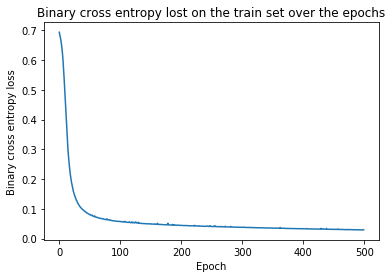

In [22]:
np.random.seed(0)
%matplotlib inline

np.random.seed(0)
# TODO
l1 = Dense((feature_count, 5), Relu())
l2 = Dense((5, 1), Sigmoid())

model = Model(optimizer=SGD(learning_rate=0.01), loss=BinaryCrossentropy())
model.add(l1)
model.add(l2)

model.train(train_features, train_labels, 500, 16)

### Evaluating the model on the test set

In [23]:
predictions = model.predict(test_features)
predicted_labels = np.where(predictions >=0.5, 1, 0)

bce = BinaryCrossentropy()

print("Loss: ", bce.forward(test_labels[:, np.newaxis], predictions))
print("Acurracy: ", accuracy_score(test_labels, predicted_labels))
print("Precison: ", precision_score(test_labels, predicted_labels))
print("Recall: ", recall_score(test_labels, predicted_labels))


Loss:  0.08809266585602174
Acurracy:  0.9821428571428571
Precison:  1.0
Recall:  0.9534883720930233


There seems to be no signs of over- or underfitting, the model has excellent performance on both the train and the test set.

# Triangles vs Circles (Basic Shapes Dataset)

For more information, see: https://www.kaggle.com/cactus3/basicshapes

In [ ]:
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1Va88vwMwmToi0SFfdTo8_9TJsV4qdOXK" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1Va88vwMwmToi0SFfdTo8_9TJsV4qdOXK" -o circles_vs_triangles_data.pkl

In [ ]:
import pickle

with open('circles_vs_triangles_data.pkl', 'rb') as f:
    data = pickle.load(f)
features, labels = data['features'], data['labels']

## Data exploration and Pre-processing
Tasks:
* Print the distribution of the labels.
* Plot some images (3 circles and 3 triangles).
* Randomly split the dataset to training and test sets. (Ratio should be 80-20.)
  * After splitting make sure that the distribution of the labels are similar. (Print the distribution of the labels.)
* Normalize the data between -1. and 1. (Use min-max scaling.)

In [ ]:
# TODO

## Define and train a model.
Tasks:
* Define a simple convolutional network as follows: 2x(Conv2D with 4 [then 8 in the second time] (3x3) kernels -> ReLU -> MaxPooling2D) -> Flatten -> Dense with 32 units -> Relu -> Dense -> Sigmoid
* Train it for 100 (or less if it is too slow...) epochs with a batch size of 16 using SGD optimizer with learning rate of 0.01.
  * Optional: Also train it with the optimized implementation, and measure the speed up. 
* Plot the learning curve.
  * Summmarize in a few words what you see. (Presence of overfitting, underfitting, ...)
* Evaluate the trained model on the test set. (Loss, accuracy, precision, recall)

In [ ]:
np.random.seed(42)
# TODO